# Polars-Bio Performance Analysis

This notebook analyzes performance test results comparing polars-bio against other genomic interval tools.
It creates visualizations showing:
- Performance comparisons across different data sizes
- Multi-core scaling analysis for polars-bio
- Summary heatmaps of relative performance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
import re
from typing import Dict, List, Tuple

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure matplotlib for better display
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

In [3]:
def load_csv_files(results_dir: str) -> Dict[str, pd.DataFrame]:
    """Load all CSV files from results directory"""
    csv_files = {}
    results_path = Path(results_dir)
    
    for csv_file in results_path.glob("*.csv"):
        # Extract operation and type from filename
        filename = csv_file.stem
        csv_files[filename] = pd.read_csv(csv_file)
        print(f"Loaded: {filename} with {len(csv_files[filename])} rows")
    
    return csv_files

def parse_test_cases(df: pd.DataFrame, filename: str) -> pd.DataFrame:
    """Parse test case sizes from the filename and add thread info"""
    df = df.copy()
    
    # Extract data size from filename (e.g., "overlap-parallel_10000000" -> 10000000)
    parts = filename.split('_')
    if len(parts) >= 2:
        try:
            data_size = int(parts[-1])
            df['data_size'] = data_size
            #print(f"Extracted data_size: {data_size} from filename: {filename}")
        except ValueError:
            df['data_size'] = 0
            print(f"Could not extract data_size from filename: {filename}")
    else:
        df['data_size'] = 0
        print(f"No data_size found in filename: {filename}")
    
    # Standardize column names
    if 'Library' in df.columns:
        df['tool'] = df['Library']
    if 'Mean (s)' in df.columns:
        df['execution_time'] = df['Mean (s)']
    
    # Extract thread count for parallel operations
    df['threads'] = 1  # default
    if 'tool' in df.columns:
        df['threads'] = df['tool'].apply(lambda x: 
            int(x.split('-')[-1]) if '-' in str(x) and x.split('-')[-1].isdigit() else 1
        )
        # Clean tool names (remove thread suffixes)
        df['tool_clean'] = df['tool'].apply(lambda x: 
            x.split('-')[0] if '-' in str(x) and x.split('-')[-1].isdigit() else x
        )
    
    
    return df

In [4]:
def create_operation_comparison_plot(data: Dict[str, pd.DataFrame], 
                                   operation: str, 
                                   output_dir: str):
    """Create comparison plot for a specific operation"""
    
    # Find files for this operation (non-parallel) - use exact match to avoid overlapping names
    operation_files = {}
    for k, v in data.items():
        if 'parallel' not in k and '-' in k:
            # Extract operation name (first part before first '-')
            file_operation = k.split('-')[0]
            if file_operation == operation:
                operation_files[k] = v
    
    if not operation_files:
        print(f"No data found for operation: {operation}")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Collect all data points
    all_data = []
    for filename, df in operation_files.items():
        df = parse_test_cases(df, filename)  # Fixed: added filename parameter
        df['filename'] = filename
        all_data.append(df)
    
    if not all_data:
        print(f"No valid data for operation: {operation}")
        return
        
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Use data directly without grouping since each test is run once
    if 'tool_clean' in combined_df.columns:
        tool_col = 'tool_clean'
    else:
        tool_col = 'tool'
    
    # Plot each tool
    for tool in combined_df[tool_col].unique():
        tool_data = combined_df[combined_df[tool_col] == tool].sort_values('data_size')
        
        # Highlight polars-bio
        if tool == 'polars_bio':
            plt.plot(tool_data['data_size'], tool_data['execution_time'], 
                    'o-', linewidth=3, markersize=8, label=tool, color='red')
        else:
            plt.plot(tool_data['data_size'], tool_data['execution_time'], 
                    'o-', alpha=0.7, label=tool)
    
    plt.xlabel('Dataset Size')
    plt.ylabel('Execution Time (s)')
    plt.title(f'Performance Comparison - Operation: {operation.upper()}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/{operation}_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
def create_parallel_analysis_plot(data: Dict[str, pd.DataFrame], 
                                operation: str, 
                                output_dir: str):
    """Create parallel performance analysis for polars-bio"""
    print(f"Creating parallel analysis plot for operation: {operation}")
    # Find parallel files for this operation - use exact match to avoid overlapping names
    parallel_files = {}
    for k, v in data.items():
        if '-parallel' in k:
            # Extract operation name before '-parallel'
            file_operation = k.split('-parallel')[0]
            if file_operation == operation:
                parallel_files[k] = v
    
    if not parallel_files:
        print(f"No parallel data found for operation: {operation}")
        return
    
    plt.figure(figsize=(14, 6))
    
    # Collect all parallel data
    all_parallel_data = []
    for filename, df in parallel_files.items():
        df = parse_test_cases(df, filename)  # Fixed: added filename parameter
        df['filename'] = filename
        all_parallel_data.append(df)
    
    if not all_parallel_data:
        print(f"No valid parallel data for operation: {operation}")
        return
        
    combined_df = pd.concat(all_parallel_data, ignore_index=True)
    
    # Filter for polars-bio only (clean tool name)
    if 'tool_clean' in combined_df.columns:
        polars_data = combined_df[combined_df['tool_clean'] == 'polars_bio'].copy()
    else:
        polars_data = combined_df[combined_df['tool'].str.startswith('polars_bio')].copy()
    
    if polars_data.empty:
        print(f"No polars-bio data found for parallel operation: {operation}")
        return
    
    # Use data directly without grouping since each test is run once
    
    # Plot 1: Performance vs Data Size for different thread counts
    plt.subplot(1, 2, 1)
    for thread_count in sorted(polars_data['threads'].unique()):
        thread_data = polars_data[polars_data['threads'] == thread_count].sort_values('data_size')
        plt.plot(thread_data['data_size'], thread_data['execution_time'], 
                'o-', label=f'{thread_count} threads', markersize=6)
    
    plt.xlabel('Dataset Size')
    plt.ylabel('Execution Time (s)')
    plt.title(f'Polars-bio: {operation.upper()} - Different Thread Counts')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # Plot 2: Speedup analysis
    plt.subplot(1, 2, 2)
    
    # Calculate speedup relative to 1 thread
    for data_size in sorted(polars_data['data_size'].unique()):
        size_data = polars_data[polars_data['data_size'] == data_size]
        
        baseline_time_data = size_data[size_data['threads'] == 1]['execution_time']
        
        if baseline_time_data.empty:
            continue
            
        baseline_time = baseline_time_data.iloc[0]
        
        speedups = []
        thread_counts = []
        
        for thread_count in sorted(size_data['threads'].unique()):
            thread_time_data = size_data[size_data['threads'] == thread_count]['execution_time']
            if thread_time_data.empty:
                continue
            thread_time = thread_time_data.iloc[0]
            speedup = baseline_time / thread_time
            speedups.append(speedup)
            thread_counts.append(thread_count)
        
        plt.plot(thread_counts, speedups, 'o-', label=f'Size: {data_size}', markersize=6)
    
    # Add ideal speedup line
    max_threads = max(polars_data['threads'])
    ideal_threads = range(1, max_threads + 1)
    plt.plot(ideal_threads, ideal_threads, '--k', alpha=0.5, label='Ideal Speedup')
    
    plt.xlabel('Number of Threads')
    plt.ylabel('Speedup vs 1 Thread')
    plt.title(f'Speedup Analysis - {operation.upper()}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/{operation}_parallel_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
def create_summary_heatmap(data: Dict[str, pd.DataFrame], output_dir: str):
    """Create a summary heatmap showing relative performance"""
    
    # Collect all performance data
    summary_data = []
    
    for filename, df in data.items():
        if 'parallel' in filename:
            continue
            
        df = parse_test_cases(df, filename)  # Fixed: added filename parameter
        operation = filename.split('-')[0]  # e.g., "overlap-single_1000" -> "overlap"
        
        # Use clean tool names - no grouping needed since each test is run once
        tool_col = 'tool_clean' if 'tool_clean' in df.columns else 'tool'
        
        for _, row in df.iterrows():
            summary_data.append({
                'operation': operation,
                'tool': row[tool_col],
                'data_size': row['data_size'],
                'execution_time': row['execution_time']
            })
    
    if not summary_data:
        print("No data available for summary heatmap")
        return
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calculate relative performance (polars-bio as baseline)
    relative_performance = []
    
    for operation in summary_df['operation'].unique():
        for data_size in summary_df['data_size'].unique():
            subset = summary_df[
                (summary_df['operation'] == operation) & 
                (summary_df['data_size'] == data_size)
            ]
            
            if subset.empty:
                continue
                
            polars_time = subset[subset['tool'] == 'polars_bio']['execution_time']
            
            if polars_time.empty:
                continue
                
            polars_time = polars_time.iloc[0]
            
            for _, row in subset.iterrows():
                # Invert the calculation: polars_time / tool_time
                # Values < 1 mean the tool is slower than polars-bio
                # Values > 1 mean the tool is faster than polars-bio
                relative_perf = polars_time / row['execution_time']
                relative_performance.append({
                    'operation': operation,
                    'tool': row['tool'],
                    'data_size': row['data_size'],
                    'relative_performance': relative_perf
                })
    
    if not relative_performance:
        print("No relative performance data available")
        return
        
    rel_df = pd.DataFrame(relative_performance)
    
    # Create pivot table for heatmap
    pivot_table = rel_df.pivot_table(
        values='relative_performance',
        index=['operation', 'data_size'],
        columns='tool',
        aggfunc='mean'  # Keep this one since we might have duplicates from different files
    )
    
    plt.figure(figsize=(12, 8))
    
    # Create custom colormap: red for polars-bio (=1), yellow/orange for slower tools (<1), green for faster (>1)
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['#FFEB3B', '#FFC107', '#FF5722', '#4CAF50']  # Yellow -> Orange -> Red -> Green
    n_bins = 100
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap=custom_cmap, 
                center=1, vmin=0, vmax=2,
                cbar_kws={'label': 'Relative Performance (1.0 = polars-bio baseline, >1 = faster, <1 = slower)'})
    plt.title('Performance Heatmap - Relative to Polars-bio')
    plt.ylabel('Operation and Data Size')
    plt.xlabel('Tool')
    plt.tight_layout()
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/performance_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
def run_complete_analysis(results_dir: str, output_dir: str):
    """Run complete performance analysis"""
    
    print("Loading data...")
    data = load_csv_files(results_dir)
    
    if not data:
        print("No CSV files found in results directory!")
        return
    
    # Identify operations
    operations = set()
    for filename in data.keys():
        # Extract operation name (e.g., "overlap-single_1000" -> "overlap")
        operation = filename.split('-')[0]
        operations.add(operation)
    
    print(f"Found operations: {operations}")
    
    # Create comparison plots for each operation
    print("\nCreating comparison plots...")
    for operation in operations:
        print(f"Processing operation: {operation}")
        create_operation_comparison_plot(data, operation, output_dir)
        create_parallel_analysis_plot(data, operation, output_dir)
    
    # Create summary heatmap
    print("\nCreating performance heatmap...")
    create_summary_heatmap(data, output_dir)
    
    print(f"\nAnalysis complete! Plots saved in: {output_dir}")

## Configuration and Execution

Set the paths to your results directory and where you want to save the plots, then run the complete analysis.

Loading fresh data...
Loaded: coverage-parallel_1000000 with 5 rows
Loaded: coverage-parallel_100000 with 5 rows
Loaded: overlap-single-small_100 with 7 rows
Loaded: coverage-single-large_1000000 with 4 rows
Loaded: coverage-parallel_10000000 with 5 rows
Loaded: overlap-parallel_10000 with 5 rows
Loaded: count_overlaps-parallel_100 with 5 rows
Loaded: coverage-single-small_100 with 5 rows
Loaded: coverage-parallel_1000 with 5 rows
Loaded: nearest-single-large_10000000 with 4 rows
Loaded: count_overlaps-parallel_100000 with 5 rows
Loaded: coverage-parallel_10000 with 5 rows
Loaded: overlap-single-large_1000000 with 4 rows
Loaded: overlap-single-large_10000000 with 4 rows
Loaded: count_overlaps-parallel_10000000 with 5 rows
Loaded: coverage-single-large_10000000 with 4 rows
Loaded: nearest-parallel_10000 with 5 rows
Loaded: count_overlaps-single-large_1000000 with 4 rows
Loaded: nearest-parallel_100 with 5 rows
Loaded: nearest-single-small_100 with 5 rows
Loaded: nearest-parallel_100000 

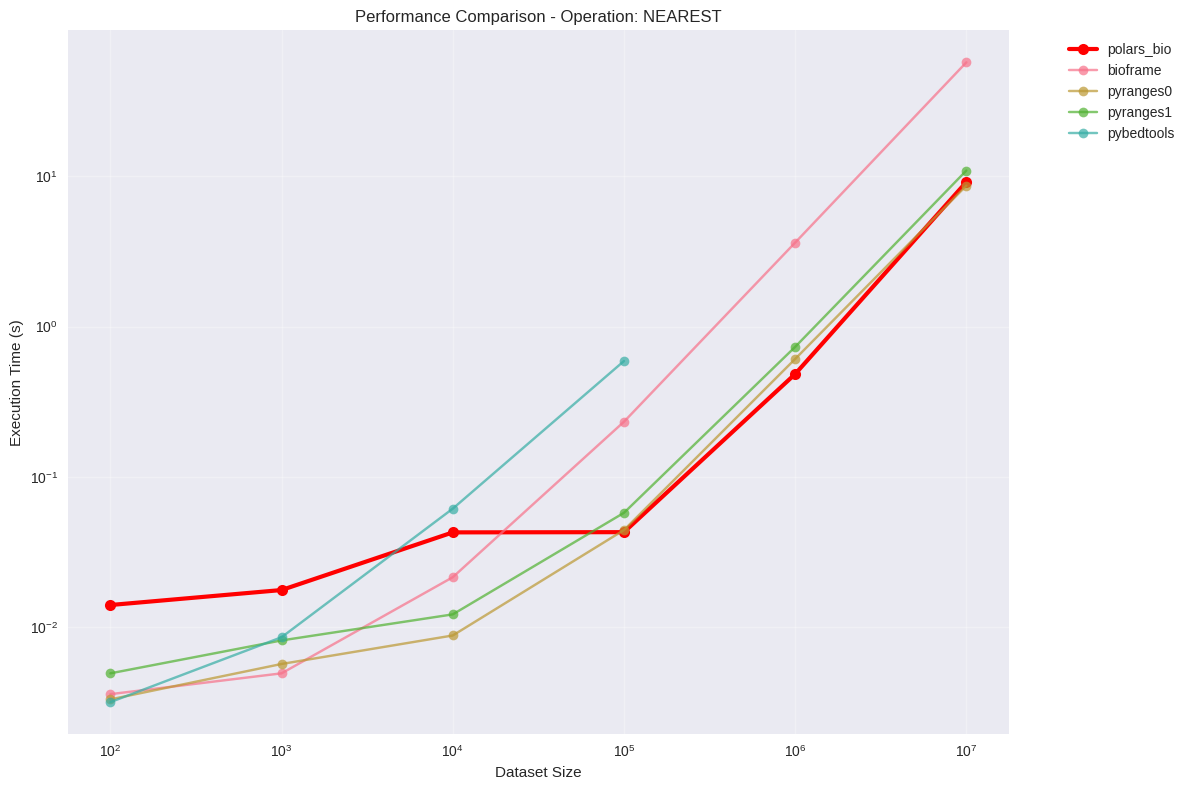

Creating parallel analysis plot for operation: nearest


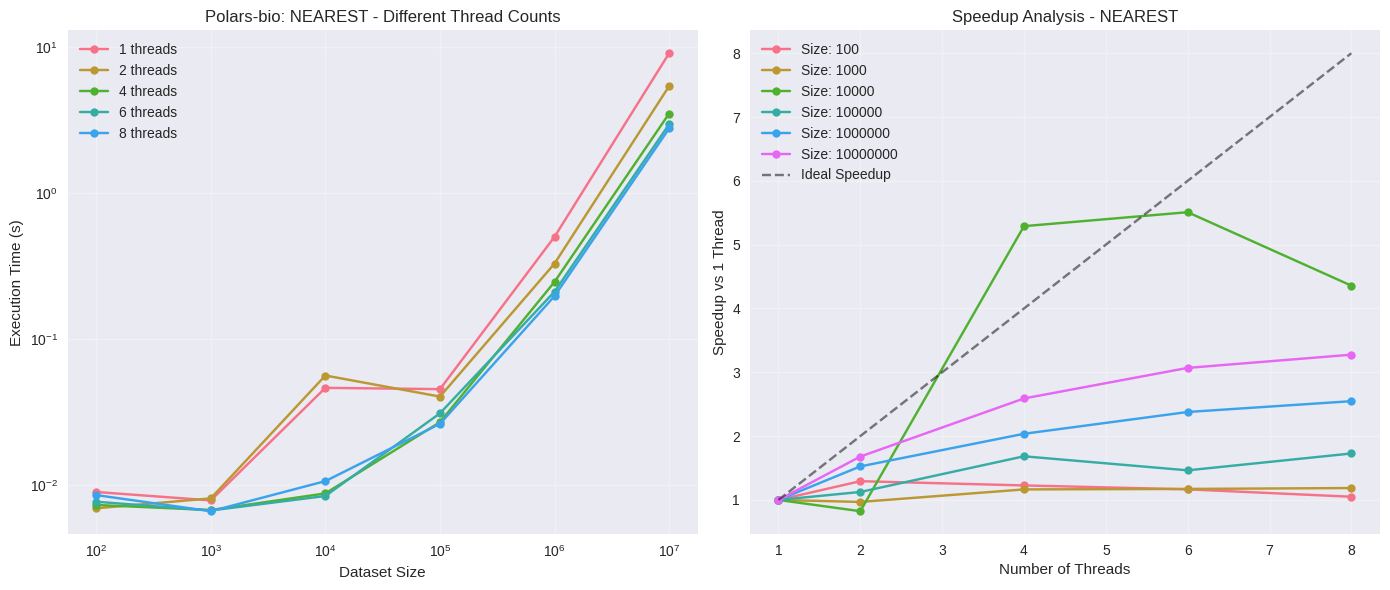

Processing operation: coverage


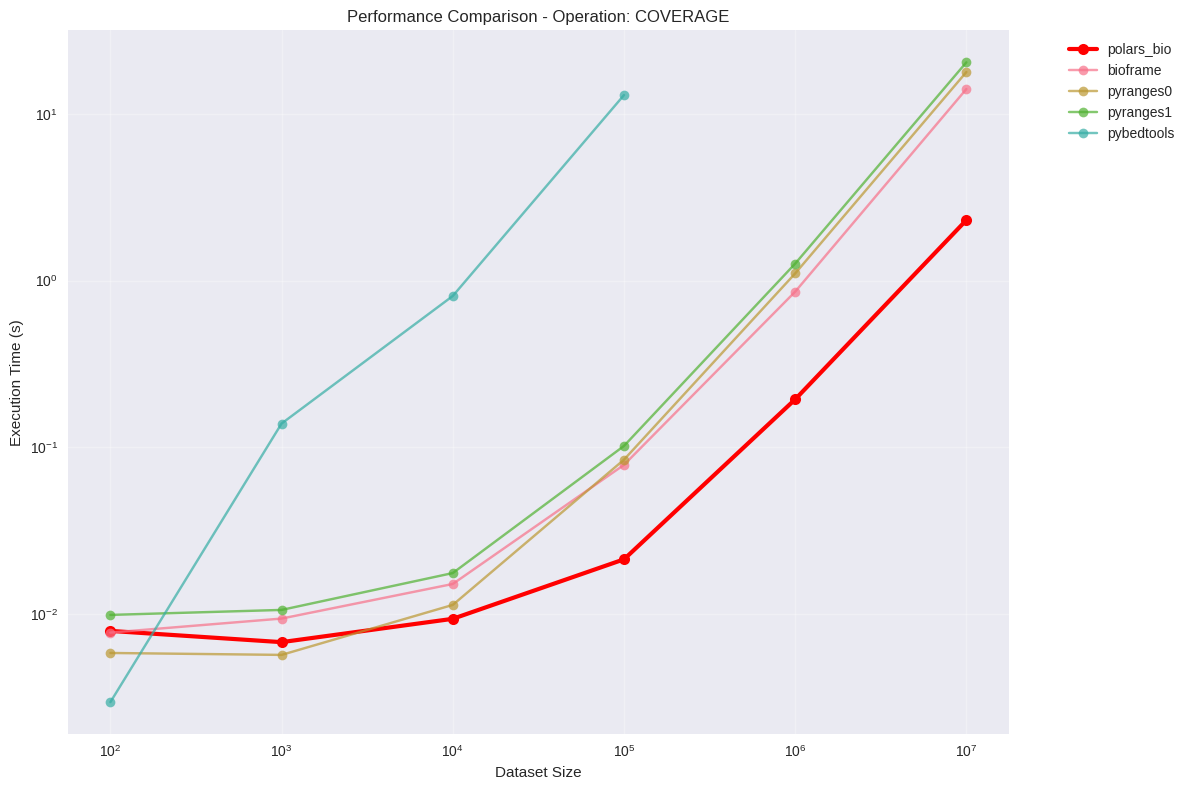

Creating parallel analysis plot for operation: coverage


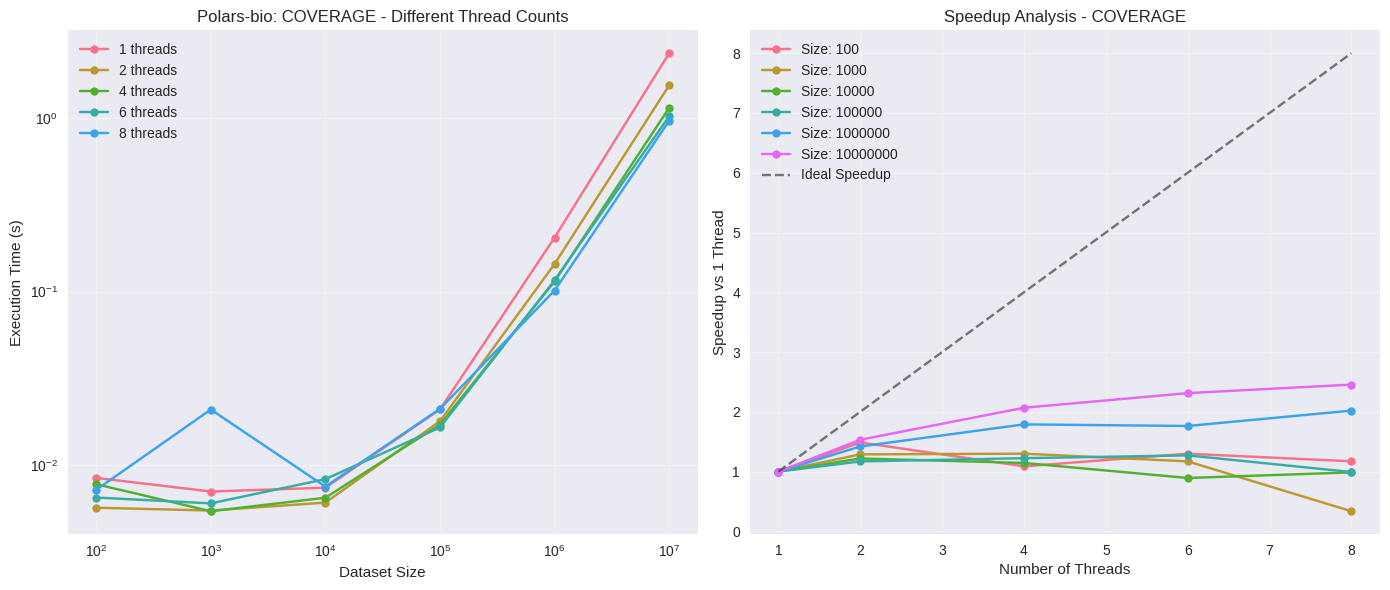

Processing operation: count_overlaps


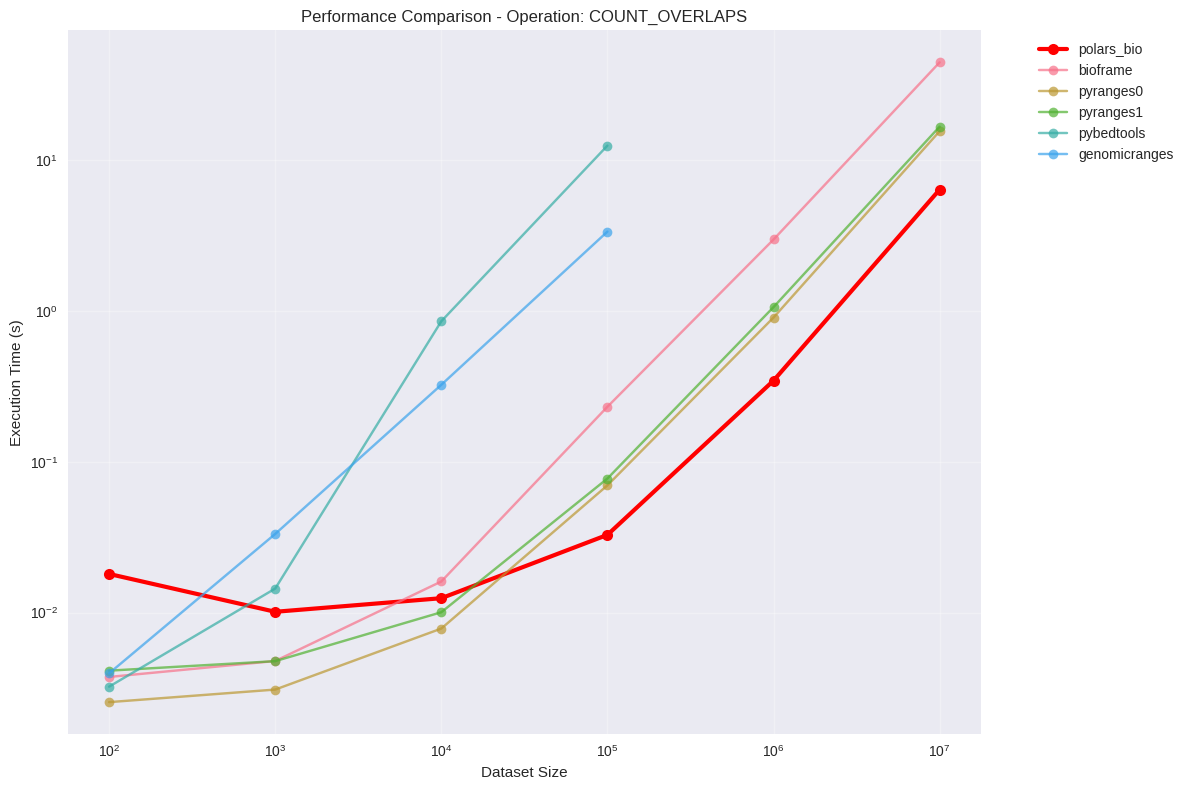

Creating parallel analysis plot for operation: count_overlaps


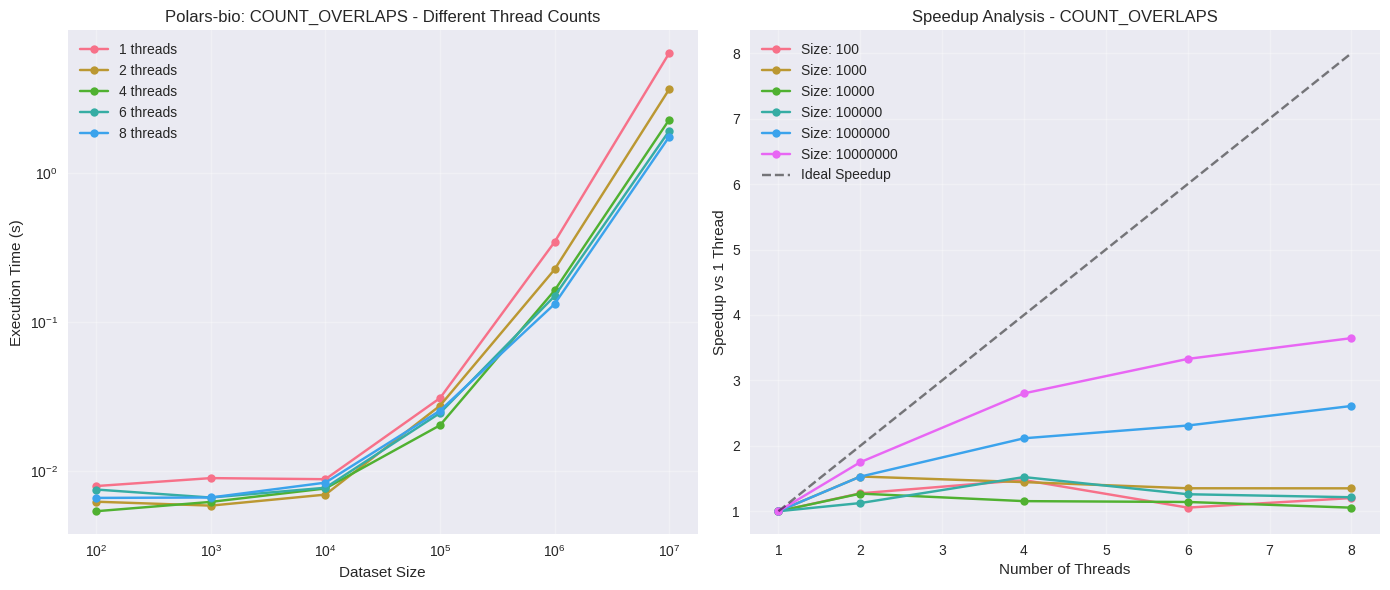

Processing operation: overlap


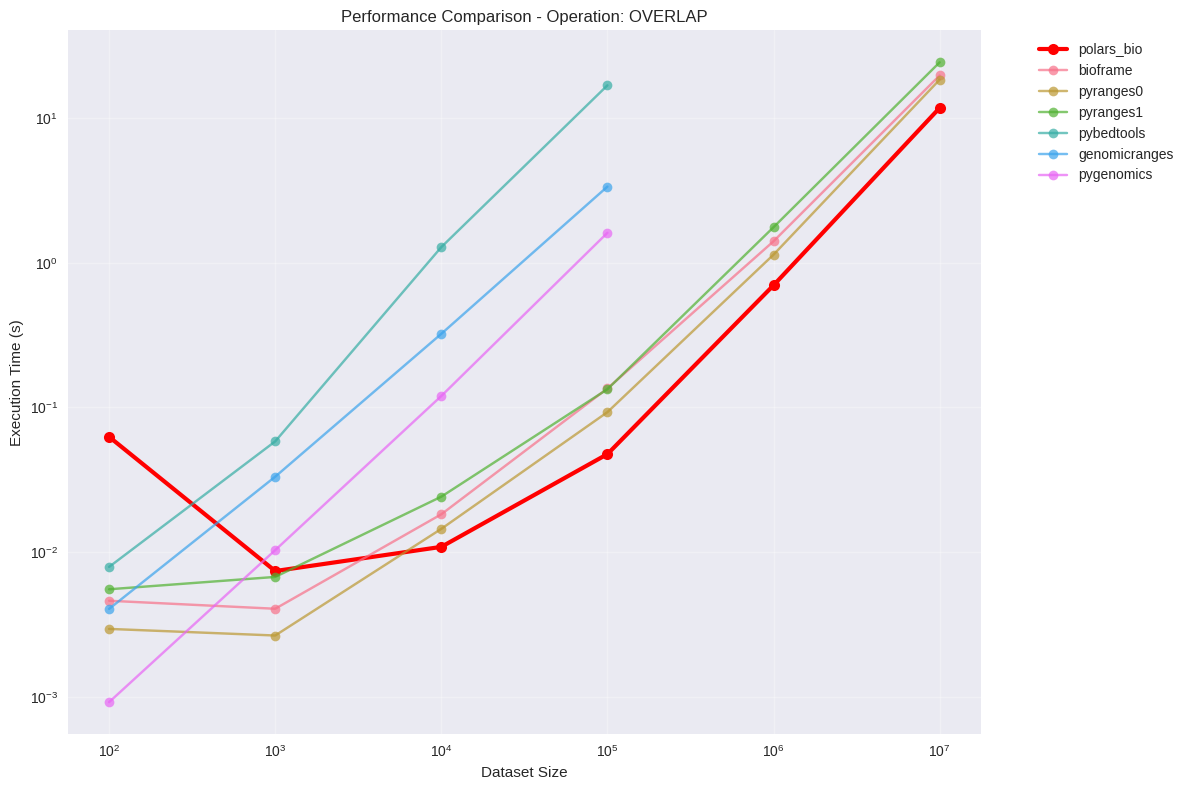

Creating parallel analysis plot for operation: overlap


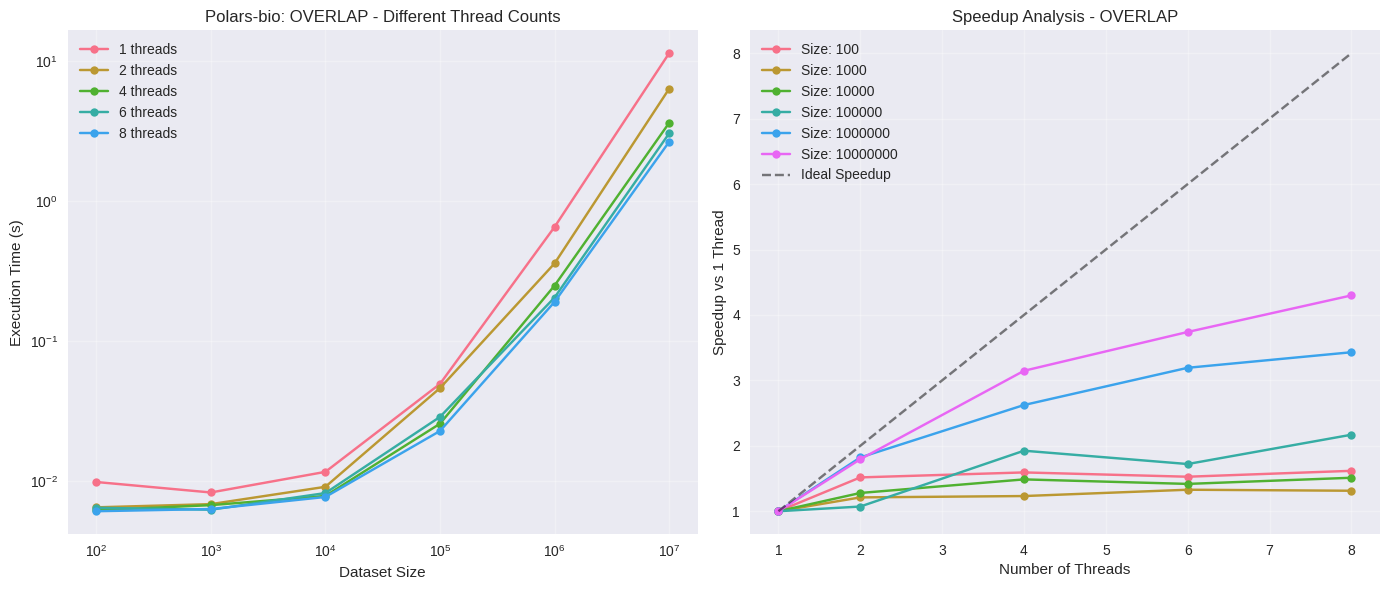


Creating performance heatmap...


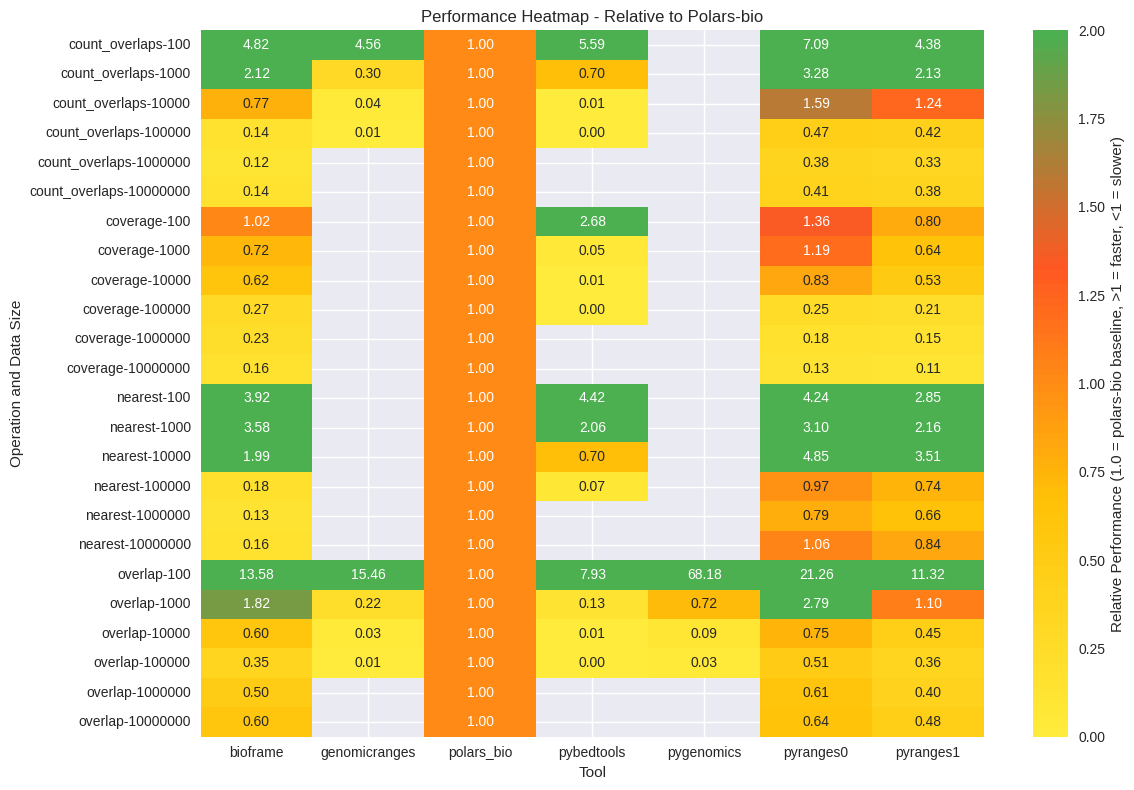


Analysis complete! Plots saved in: performance_plots


In [8]:
# Clear any previously loaded data
if 'data' in locals():
    del data
    print("Cleared previous data from memory")

# Set your data directory
#results_directory = "/home/tgambin/workspace/polars-bio-bench/results/2025-06-17 22:13:41/"
results_directory = "/home/tgambin/workspace/polars-bio-bench/results/2025-06-18 19:49:40/"

output_directory = "performance_plots"

# Load fresh data
print("Loading fresh data...")
data = load_csv_files(results_directory)

# Test with overlap-parallel files specifically
overlap_parallel_files = {}
for k, v in data.items():
    if '-parallel' in k:
        # Extract operation name before '-parallel'
        file_operation = k.split('-parallel')[0]
        if file_operation == 'overlap':
            overlap_parallel_files[k] = v
            
print(f"\nFound overlap-parallel files: {list(overlap_parallel_files.keys())}")

# Test with count_overlaps-parallel files 
count_overlaps_parallel_files = {}
for k, v in data.items():
    if '-parallel' in k:
        # Extract operation name before '-parallel'
        file_operation = k.split('-parallel')[0]
        if file_operation == 'count_overlaps':
            count_overlaps_parallel_files[k] = v
            
print(f"Found count_overlaps-parallel files: {list(count_overlaps_parallel_files.keys())}")


run_complete_analysis(results_directory, output_directory)

## Individual Analysis Functions

You can also run individual analysis functions if you want to focus on specific aspects:

In [9]:
# Load data first
data = load_csv_files(results_directory)

# Example: Create comparison plot for 'overlap' operation only
# create_operation_comparison_plot(data, 'overlap', output_directory)

# Example: Create parallel analysis for 'nearest' operation only
# create_parallel_analysis_plot(data, 'nearest', output_directory)

# Example: Create only the summary heatmap
# create_summary_heatmap(data, output_directory)

print("Individual analysis functions are ready to use!")

Loaded: coverage-parallel_1000000 with 5 rows
Loaded: coverage-parallel_100000 with 5 rows
Loaded: overlap-single-small_100 with 7 rows
Loaded: coverage-single-large_1000000 with 4 rows
Loaded: coverage-parallel_10000000 with 5 rows
Loaded: overlap-parallel_10000 with 5 rows
Loaded: count_overlaps-parallel_100 with 5 rows
Loaded: coverage-single-small_100 with 5 rows
Loaded: coverage-parallel_1000 with 5 rows
Loaded: nearest-single-large_10000000 with 4 rows
Loaded: count_overlaps-parallel_100000 with 5 rows
Loaded: coverage-parallel_10000 with 5 rows
Loaded: overlap-single-large_1000000 with 4 rows
Loaded: overlap-single-large_10000000 with 4 rows
Loaded: count_overlaps-parallel_10000000 with 5 rows
Loaded: coverage-single-large_10000000 with 4 rows
Loaded: nearest-parallel_10000 with 5 rows
Loaded: count_overlaps-single-large_1000000 with 4 rows
Loaded: nearest-parallel_100 with 5 rows
Loaded: nearest-single-small_100 with 5 rows
Loaded: nearest-parallel_100000 with 5 rows
Loaded: co

## Data Exploration

Explore the loaded data to understand its structure:

In [10]:
# Explore the loaded data
if 'data' in locals():
    print("Available datasets:")
    for filename, df in data.items():
        print(f"\n{filename}:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        if not df.empty:
            print(f"  Tools: {df['tool'].unique() if 'tool' in df.columns else 'N/A'}")
            print(f"  Test cases: {df['test_case'].unique() if 'test_case' in df.columns else 'N/A'}")
else:
    print("Data not loaded yet. Run the analysis cell first.")

Available datasets:

coverage-parallel_1000000:
  Shape: (5, 5)
  Columns: ['Library', 'Min (s)', 'Max (s)', 'Mean (s)', 'Speedup']
  Tools: N/A
  Test cases: N/A

coverage-parallel_100000:
  Shape: (5, 5)
  Columns: ['Library', 'Min (s)', 'Max (s)', 'Mean (s)', 'Speedup']
  Tools: N/A
  Test cases: N/A

overlap-single-small_100:
  Shape: (7, 5)
  Columns: ['Library', 'Min (s)', 'Max (s)', 'Mean (s)', 'Speedup']
  Tools: N/A
  Test cases: N/A

coverage-single-large_1000000:
  Shape: (4, 5)
  Columns: ['Library', 'Min (s)', 'Max (s)', 'Mean (s)', 'Speedup']
  Tools: N/A
  Test cases: N/A

coverage-parallel_10000000:
  Shape: (5, 5)
  Columns: ['Library', 'Min (s)', 'Max (s)', 'Mean (s)', 'Speedup']
  Tools: N/A
  Test cases: N/A

overlap-parallel_10000:
  Shape: (5, 5)
  Columns: ['Library', 'Min (s)', 'Max (s)', 'Mean (s)', 'Speedup']
  Tools: N/A
  Test cases: N/A

count_overlaps-parallel_100:
  Shape: (5, 5)
  Columns: ['Library', 'Min (s)', 'Max (s)', 'Mean (s)', 'Speedup']
  Tools: